In [1]:
import matplotlib

matplotlib.rcParams["font.size"] = 15

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

AQMS = ["FIFO", "FIFO (ECN)", "CoDel", "FQ", "FQ-CoDel", "DualPI2"]
BDPS = [0.5, 1.0, 2.0, 4.0, 8.0]
KERNEL_NAME = {
    "patched": "5.15.725.15-prague-lhagen+",
    "unpatched": "5.15.72-56eae305c-prague-91",
}
KERNELS = list(KERNEL_NAME.keys())
CCA_NAME = {
    "cubic": "Cubic",
    "bbr2": "BBRv2",
}
CLASSIC_CCAS = list(CCA_NAME.keys())
REPETITIONS = 10

df = pd.read_csv("../data/reproduce.csv")
df = df.set_index(list(df.columns[:5])).sort_index()

ordered_index = pd.MultiIndex.from_product(
    [CLASSIC_CCAS, AQMS, BDPS, list(range(REPETITIONS))],
    names=["classic_cca", "aqm", "bdp", "i"],
)

In [2]:
def plot_throughput(df, ax, title=None):
    data = df.values.reshape([len(AQMS), len(BDPS), REPETITIONS])
    data = data / 1_000_000  # convert to Mbit
    data = np.mean(data, axis=2)
    data = np.round(data, decimals=1)

    img = ax.imshow(data, cmap=plt.cm.coolwarm, vmin=0, vmax=100)
    ax.set_xticks(range(len(BDPS)), labels=BDPS)
    ax.set_yticks(range(len(AQMS)), labels=AQMS)

    for y, row in enumerate(data):
        for x, val in enumerate(row):
            ax.text(x, y, val, va="center", ha="center")

    ax.set_xlabel("Buffer Size (BDP)")

    if title is not None:
        ax.set_title(title)

    return img


def plot_scenario(df, figsize, title=None, file=None):
    fig, axes = plt.subplots(
        1, len(CLASSIC_CCAS), layout="constrained", figsize=figsize, sharey=True
    )

    if title is not None:
        fig.suptitle(title)

    for cca, ax in zip(CLASSIC_CCAS, axes):
        img = plot_throughput(df.loc[cca], ax, title=f"Prague vs. {CCA_NAME[cca]}")

    cbar = fig.colorbar(img)
    cbar.set_label(
        "Prague Throughput (Mbps)",
        rotation=270,
        size="large",
        labelpad=10,
    )

    if file is not None:
        plt.savefig(file)

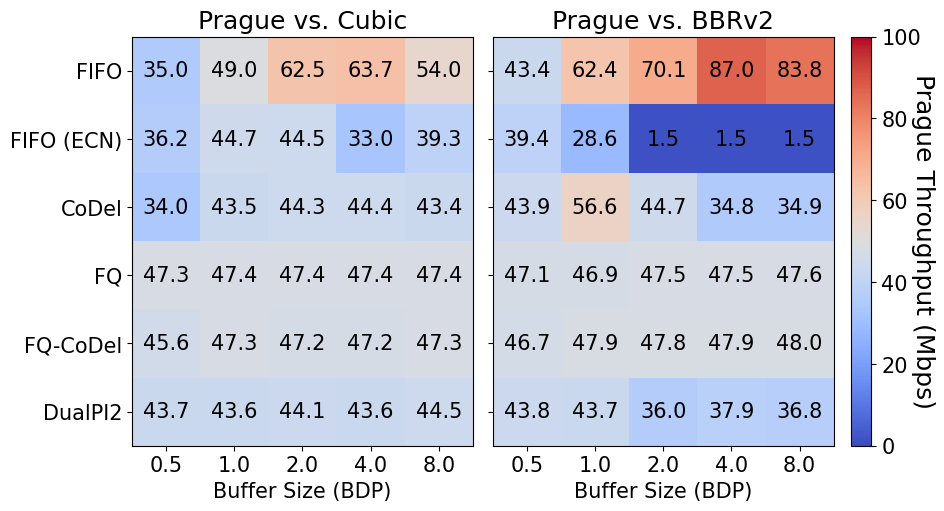

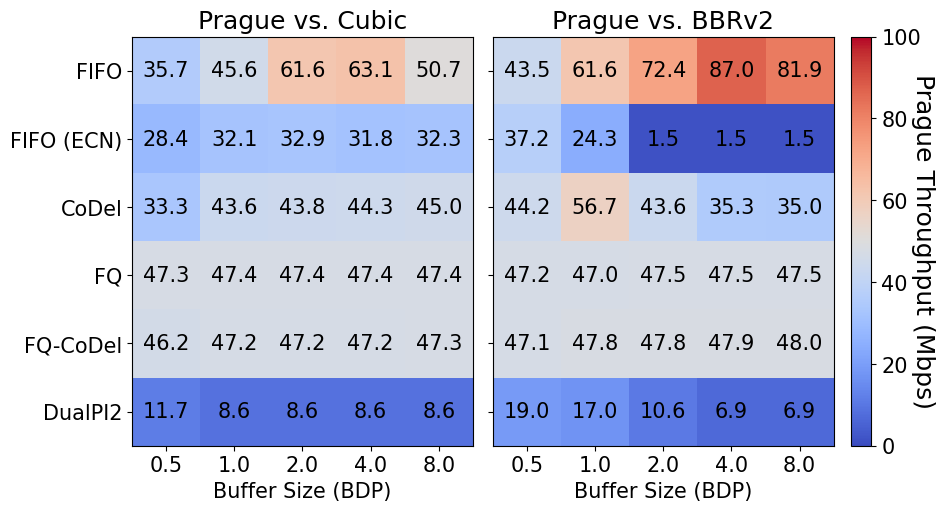

In [4]:
for kernel in KERNELS:
    plot_scenario(
        df["prague throughput"].loc[KERNEL_NAME[kernel]].reindex(ordered_index),
        figsize=(9.3, 5),
        file=f"images/reproduce/{kernel}/throughput.pdf",
    )